In [1]:
!pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 14.6 MB/s 
     |████████████████████████████████| 1.0 MB 59.3 MB/s 


In [39]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

import nltk

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import WordCloud
# Tools for preprocessing input data
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from pyvi import ViTokenizer, ViPosTagger 
# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding
from keras.utils import pad_sequences
# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os

In [4]:
import gensim
print(gensim.__version__)

4.2.0


In [5]:
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [7]:
path = '/content/Food-Comments-Sentiment-Analysis'
isExist = os.path.exists(path)
if not isExist:
  !git clone https://github.com/cuongprotector/Food-Comments-Sentiment-Analysis.git

Cloning into 'Food-Comments-Sentiment-Analysis'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 107 (delta 16), reused 0 (delta 0), pack-reused 72
Receiving objects: 100% (107/107), 43.91 MiB | 13.06 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [8]:
train_df = pd.read_csv("/content/Food-Comments-Sentiment-Analysis/food_train.csv",encoding='UTF8')
train_df['Comment'] = train_df['Comment'].astype('str')

In [9]:
sub_df = pd.read_csv("/content/Food-Comments-Sentiment-Analysis/test.csv",encoding='UTF8')
sub_df['Comment'] = sub_df['Comment'].astype('str')

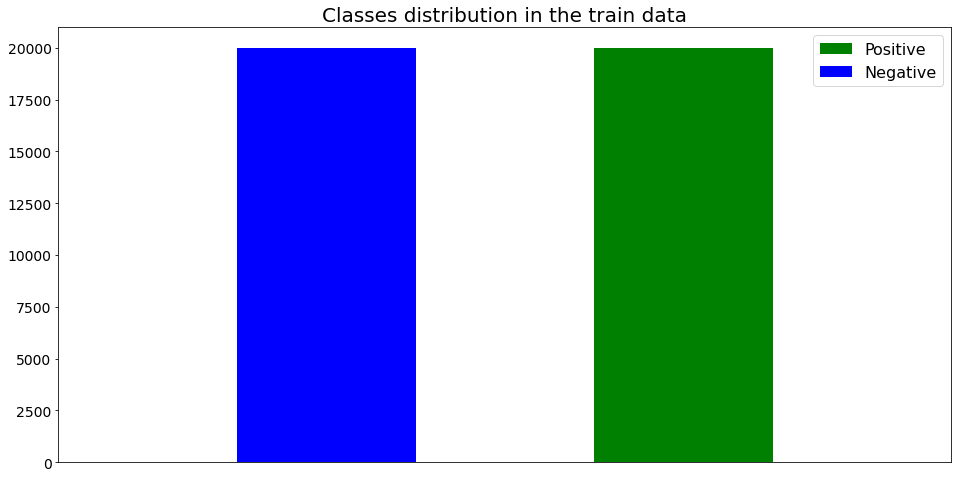

In [10]:
plt.hist(train_df[train_df.Rating == 1].Rating,
         bins=2, color='green', label='Positive')
plt.hist(train_df[train_df.Rating == 0].Rating,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=LARGE_SIZE)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [11]:
def get_visuals(df,column_name,value):
    s=','
    for element in df[df[column_name]==value]['Comment']:
        s+=str(element)
    
    wordcloud=WordCloud(background_color='white',
                    random_state=101,
                   width=800,
                   height=800).generate(s)
    
    plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(wordcloud)
    plt.show()

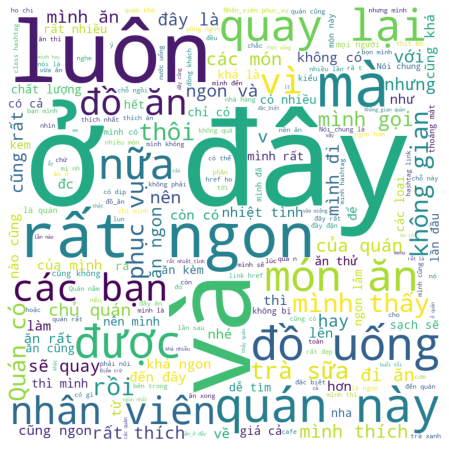

In [12]:
get_visuals(train_df,'Rating',1)

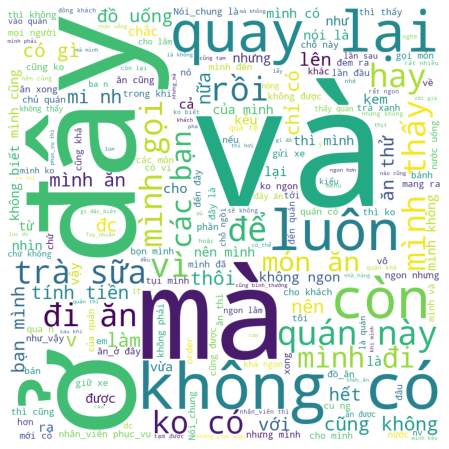

In [13]:
get_visuals(train_df,'Rating',0)

In [14]:
def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    return lemmatized_tokens


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Split into individual words
    review = ViTokenizer.tokenize(review)
    tokens = word_tokenize(review)
    # 2. Lemmatize
    lemmas = lemmatize(tokens)
    # 3. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [15]:
counter = 0
lemmatizer = WordNetLemmatizer()

In [16]:
subcmt_list = np.array(list(map(lambda x: preprocess(x, len(sub_df['Comment'])), sub_df['Comment'])))
counter = 0

In [17]:
traincmt_list = np.array(list(map(lambda x: preprocess(x, len(train_df['Comment'])), train_df['Comment'])))

In [18]:
X_train_data = traincmt_list
Y_train_data = train_df.Rating.values
X_submission = subcmt_list

In [19]:
H = []
for i in range(len(X_train_data)):
  H.append(len(X_train_data[i]))
train_df['review_lenght'] = np.array(H)
median = train_df['review_lenght'].median()
mean = train_df['review_lenght'].mean()
mode = train_df['review_lenght'].mode()[0]

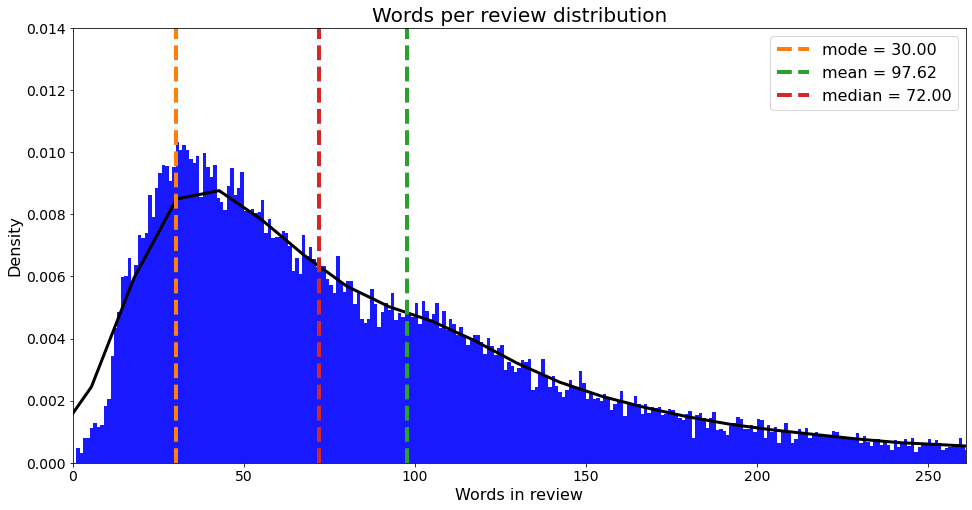

In [20]:
fig, ax = plt.subplots()
sb.distplot(train_df['review_lenght'], bins=train_df['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_df['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

In [21]:
bigrams = Phrases(sentences=traincmt_list)

In [22]:
trigrams = Phrases(sentences=bigrams[traincmt_list])

In [23]:
embedding_vector_size = 256
trigrams_model = Word2Vec(sentences = trigrams[bigrams[traincmt_list]],
                          vector_size  =embedding_vector_size,
                          min_count=3, window=5, workers=4)

In [24]:
print("Vocabulary size:", len(trigrams_model.wv.key_to_index))

Vocabulary size: 33049


In [25]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab)#.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[traincmt_list]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(sequences=vectorize_data(X_data, vocab=trigrams_model.wv.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 2min 55s, sys: 508 ms, total: 2min 55s
Wall time: 3min 10s


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, Y_train_data,  test_size=0.20,  shuffle=True, random_state=42)

In [27]:
trigrams_model.wv.vectors

array([[ 1.75510526e-01,  4.30757999e-01,  1.61610693e-01, ...,
        -3.14336941e-02, -2.25101829e-01,  5.33467114e-01],
       [ 2.53425837e-02, -2.82551676e-01, -6.46387041e-01, ...,
         3.82960737e-01, -1.28279060e-01,  4.30301577e-03],
       [-6.78332865e-01, -9.30585682e-01,  8.47801745e-01, ...,
        -1.82342604e-01, -6.08681202e-01,  7.94436514e-01],
       ...,
       [-1.23673386e-03, -2.97097284e-02,  3.67678993e-04, ...,
        -2.78398115e-03, -5.42801283e-02,  1.07103782e-02],
       [ 3.15828831e-03, -1.44399125e-02, -8.90715234e-03, ...,
         4.13119706e-04, -4.73365374e-02,  1.42112309e-02],
       [ 9.74118989e-03, -3.14727463e-02, -7.23679736e-03, ...,
         1.34850098e-02, -3.23494300e-02,  2.32092496e-02]], dtype=float32)

In [28]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 256)          8460544   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [29]:
model.compile(loss="binary_crossentropy",  optimizer='adam',  metrics=['AUC'])

history = model.fit(x=X_train,  y=y_train,  validation_data=(X_test, y_test),  batch_size=100,   epochs=4)
model.save('/content/Bi_LSTM.h5')

Epoch 1/4
320/320 [==============================] - 329s 1s/step - loss: 0.4320 - auc: 0.8823 - val_loss: 0.3684 - val_auc: 0.9231
Epoch 2/4
320/320 [==============================] - 320s 1s/step - loss: 0.3428 - auc: 0.9267 - val_loss: 0.3248 - val_auc: 0.9348
Epoch 3/4
320/320 [==============================] - 321s 1s/step - loss: 0.3140 - auc: 0.9382 - val_loss: 0.3127 - val_auc: 0.9427
Epoch 4/4
320/320 [==============================] - 323s 1s/step - loss: 0.2976 - auc: 0.9446 - val_loss: 0.3021 - val_auc: 0.9442


In [40]:
model = keras.models.load_model('/content/Bi_LSTM.h5')

In [30]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,  normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [31]:
%%time
prediction_train = model.predict(X_train)
# Get labels based on probability 1 if p>= 0.5 else 0
y_train_pred = []
for i in prediction_train:
    if i >= 0.5:
        y_train_pred.append(1)
    else:
        y_train_pred.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_train, y_train_pred))

prediction_test = model.predict(X_test)
# Get labels based on probability 1 if p>= 0.5 else 0
y_test_pred = []
for i in prediction_test:
    if i >= 0.5:
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test, y_test_pred))


#y_train_pred = model.predict(X_train)# > 0.5).astype("int32")
#y_test_pred = model.predict(X_test) #> 0.5).astype("int32")
#y_train_pred = np.argmax(model.predict(X_train), axis=-1)
#y_test_pred = np.argmax(model.predict(X_test), axis=-1)

1000/1000 [==============================] - 78s 77ms/step
Accuracy of prediction on test set :  0.8922908522283034
250/250 [==============================] - 19s 74ms/step
Accuracy of prediction on test set :  0.8740305228921691
CPU times: user 1min 35s, sys: 535 ms, total: 1min 36s
Wall time: 1min 42s


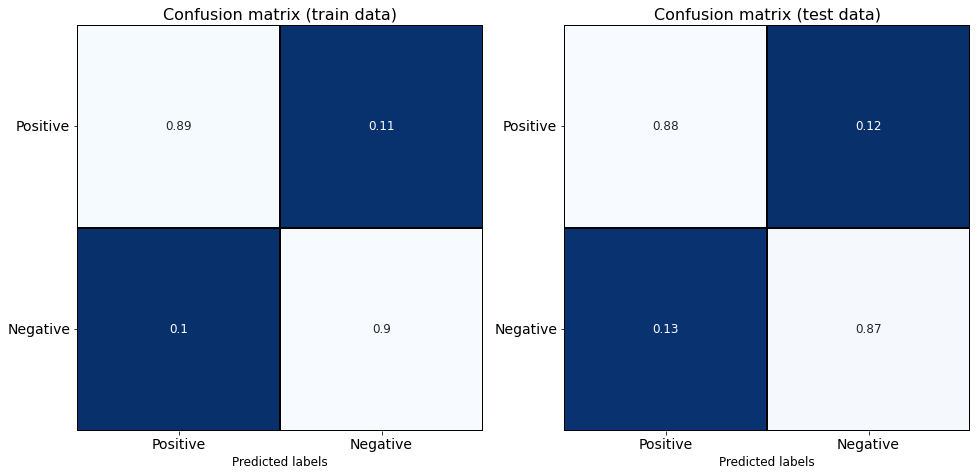

In [32]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

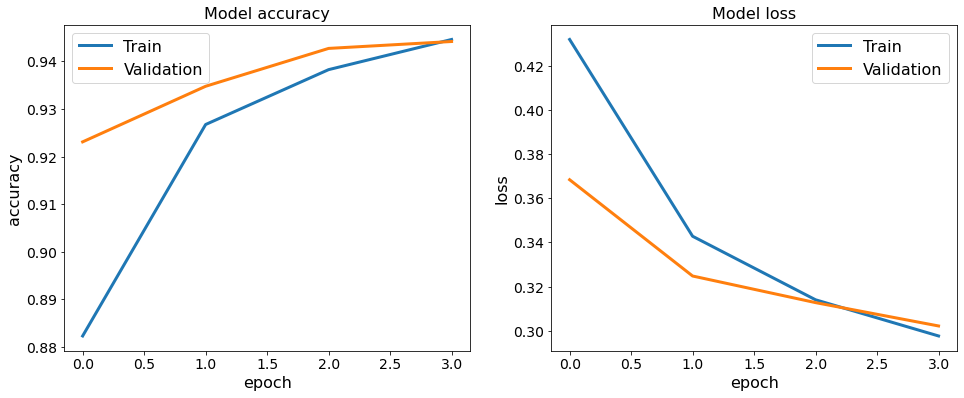

In [33]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['auc'], label='Train', linewidth=3)
axis1.plot(history.history['val_auc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [34]:
print('Convert sentences to sentences with ngrams...', end='\r')
X_submit = trigrams[bigrams[X_submission]]
print('Convert sentences to sentences with ngrams... (done)')
X_sub = pad_sequences(sequences=vectorize_data(X_submit, vocab=trigrams_model.wv.key_to_index),
                      maxlen=input_length,
                      padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [35]:
%%time
prediction_test = model.predict(X_sub)
# Get labels based on probability 1 if p>= 0.5 else 0
y_train_pred = []
for i in prediction_test:
  y_train_pred.append(i[0])

#Y_sub_pred = np.argmax(model.predict(X_sub), axis=-1)
#Y_sub_pred = model.predict_classes(X_sub)

160/160 [==============================] - 12s 76ms/step
CPU times: user 12.2 s, sys: 80.6 ms, total: 12.3 s
Wall time: 20.5 s


In [36]:
testData = pd.read_csv('/content/Food-Comments-Sentiment-Analysis/test.csv',encoding='UTF8')
testData.head()

,Unnamed: 0,RevId,UserId,Comment,image_urls
0,0,781115,1326532,Trà táo 35k\r\nCookie socola 38k \r\nNước ở đâ...,['https://images.foody.vn/res/g8/73091/s800/fo...
1,1,1219481,422306,Hôm rồi trung tâm mình tổ chức noel party ở đâ...,['https://images.foody.vn/res/g1/33/s800/foody...
2,2,1703765,9779143,Thịt gà của quán là nhất đấy. Đi ăn gọi liền 4...,['https://images.foody.vn/res/g66/659655/s800/...
3,3,4870346,12924388,Hai đứa ăn xong đau bụng cả ngày\r\nChân gà ok...,['https://images.foody.vn/res/g78/772244/s800/...
4,4,2638711,1134279,Mình vừa thử trưa nay. Điểm cộng đầu tiên là b...,['https://images.foody.vn/res/g74/737874/s800/...


In [41]:
def submit(predictions):
    testData['Rating'] = predictions
    testData.to_csv('/content/submission_Bi-LSTM.csv', index=False, columns=['RevId','Rating'])

submit(y_train_pred)